In [29]:
import os
os.sys.path.append('../Models/')
import tfanfis
# import membership.mfDerivs
# import membership.membershipfunction
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [30]:
import time

def convert_to_timestamp(x):
    """Convert date objects to integers
    
    convert_to_timestamp('2019-07-29T00:00:00')
    >>> 1564333200.0
    
    """
    x = pd.to_datetime(x)
    
    return time.mktime(x.timetuple())


def normalize(data):
    """Normalize the DF using min/max"""
    scaler = MinMaxScaler()
    return scaler.fit_transform(data)

def normalizeDate(data):
    data = data.apply(convert_to_timestamp)
    return normalize(data)

def onCompleteCallback(sarg):
    print("Training complete")
    return sarg

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

def split_data(X, y, batch_size):
    # adjust X and y for batch_size
    adj_id = np.arange(len(y) - len(y)%batch_size)
    X, y = X[adj_id, :], y[adj_id]
    
    # split test & train according to batches
    batches = len(y) / batch_size
    train_batches = np.round(batches*0.6) / batches
    
    train_id = np.arange(len(y)*train_batches, dtype=int)
    test_id = np.arange(len(y)*train_batches, len(y), dtype=int)
    
    X_train, y_train, X_test, y_test = X[train_id,:], y[train_id], X[test_id,:], y[test_id]

    return X, X_train, X_test, y, y_train, y_test

def createDataset(X, y, n_obs=10, n_input=2, batch_size=16, lag=1):
    # standardize   
    scaler = StandardScaler()   
    X = scaler.fit_transform(X)
    
    scaler = StandardScaler()   
    y = scaler.fit_transform(y)
          
    # split data into test and train set
    X, X_train, X_test, y, y_train, y_test = split_data(X, y, batch_size)

    return X, X_train, X_test, y, y_train, y_test

# Generate a input matrix X from time series y
def gen_X_from_y(x, n_input=1, lag=1):    
    n_obs = len(x) - n_input*lag
    
    data = np.zeros((n_obs, n_input+1))
    for t in range(n_input*lag, n_obs + n_input*lag):
        data[t - n_input*lag,:] = [x[t-i*lag] for i in range(n_input+1)]
    X = data[:,1:].reshape(n_obs,-1)
    y = data[:,0].reshape(n_obs,1)
    
    return X.astype('float32'), y.astype('float32')

In [31]:
baseurl = "https://github.com/wildangunawan/Dataset-Saham-IDX/raw/master/Saham/Semua/{}.csv"
df = pd.read_csv(baseurl.format("ACES"))
df

,date,previous,open_price,first_trade,high,low,close,change,volume,value,...,bid_volume,listed_shares,tradeble_shares,weight_for_index,foreign_sell,foreign_buy,delisting_date,non_regular_volume,non_regular_value,non_regular_frequency
0,2019-07-29T00:00:00,1800.0,0.0,0.0,1825.0,1770.0,1800.0,0.0,3685600.0,6.628270e+09,...,268500.0,1.715000e+10,1.715000e+10,1.715000e+10,1020200.0,2954200.0,NaN,0.0,0.000000e+00,0.0
1,2019-07-30T00:00:00,1800.0,0.0,0.0,1830.0,1785.0,1805.0,5.0,4619600.0,8.311164e+09,...,25100.0,1.715000e+10,1.715000e+10,1.715000e+10,3823200.0,3442900.0,NaN,1885329.0,3.393592e+09,3.0
2,2019-07-31T00:00:00,1805.0,0.0,0.0,1840.0,1795.0,1835.0,30.0,6431600.0,1.166963e+10,...,30000.0,1.715000e+10,1.715000e+10,1.715000e+10,3322400.0,3889100.0,NaN,70.0,1.267000e+05,1.0
3,2019-08-01T00:00:00,1835.0,0.0,0.0,1835.0,1755.0,1755.0,-80.0,12070500.0,2.137794e+10,...,668000.0,1.715000e+10,1.715000e+10,1.715000e+10,8486200.0,4504000.0,NaN,8296737.0,1.498515e+10,4.0
4,2019-08-02T00:00:00,1755.0,0.0,0.0,1785.0,1715.0,1715.0,-40.0,13368500.0,2.338670e+10,...,290700.0,1.715000e+10,1.715000e+10,1.715000e+10,10324600.0,5412400.0,NaN,1239894.0,2.139564e+09,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,2021-07-05T00:00:00,1325.0,1340.0,1335.0,1420.0,1335.0,1420.0,95.0,20959300.0,2.906057e+10,...,92600.0,1.715000e+10,1.715000e+10,1.715000e+10,3632600.0,14741800.0,NaN,3200000.0,4.425600e+09,1.0
475,2021-07-06T00:00:00,1420.0,1425.0,1425.0,1490.0,1425.0,1485.0,65.0,27145900.0,3.991402e+10,...,1085600.0,1.715000e+10,1.715000e+10,1.715000e+10,6239400.0,21318700.0,NaN,2590800.0,3.825430e+09,14.0
476,2021-07-07T00:00:00,1485.0,1500.0,1505.0,1600.0,1500.0,1565.0,80.0,42670900.0,6.636328e+10,...,295500.0,1.715000e+10,1.715000e+10,1.715000e+10,9996800.0,25230200.0,NaN,3204639.0,4.960628e+09,3.0
477,2021-07-08T00:00:00,1565.0,1570.0,1570.0,1585.0,1540.0,1570.0,5.0,28250200.0,4.397844e+10,...,2000.0,1.715000e+10,1.715000e+10,1.715000e+10,14191300.0,25253800.0,NaN,5031286.0,7.829755e+09,9.0


In [32]:
feature, label = df.loc[:,["date", "open_price"]], df.loc[:,["high"]]
feature, label

(                    date  open_price
 0    2019-07-29T00:00:00         0.0
 1    2019-07-30T00:00:00         0.0
 2    2019-07-31T00:00:00         0.0
 3    2019-08-01T00:00:00         0.0
 4    2019-08-02T00:00:00         0.0
 ..                   ...         ...
 474  2021-07-05T00:00:00      1340.0
 475  2021-07-06T00:00:00      1425.0
 476  2021-07-07T00:00:00      1500.0
 477  2021-07-08T00:00:00      1570.0
 478  2021-07-09T00:00:00      1570.0
 
 [479 rows x 2 columns],
        high
 0    1825.0
 1    1830.0
 2    1840.0
 3    1835.0
 4    1785.0
 ..      ...
 474  1420.0
 475  1490.0
 476  1600.0
 477  1585.0
 478  1570.0
 
 [479 rows x 1 columns])

NameError: name 'feature' is not defined

In [33]:
# feature['date'] = feature['date'].apply(convert_to_timestamp)
normalizedFeature = pd.DataFrame({
    'date': [],
    'open_price': [],
})
normalizedLabel = pd.DataFrame({
    'high': [],
})
normalizedFeature['open_price'] = normalize(
    np.array( feature['open_price'] )
    .reshape(-1, 1)
).flatten()
normalizedFeature['date'] = normalize(
    np.array( feature['date'].apply(convert_to_timestamp) )
    .reshape(-1, 1)
).flatten()
# label
normalizedLabel['high'] = normalize(
    np.array(label['high'])
    .reshape(-1, 1)
).flatten()

In [34]:
data = normalizedFeature
trainSize = int(len(data) * 7/10)
testSize = len(data)-trainSize
# trainSize = 300
data

,date,open_price
0,0.000000,0.000000
1,0.001406,0.000000
2,0.002813,0.000000
3,0.004219,0.000000
4,0.005626,0.000000
...,...,...
474,0.994374,0.724324
475,0.995781,0.770270
476,0.997187,0.810811
477,0.998594,0.848649


In [35]:
# look_back = 128
dtrain = data[0:trainSize]
dtest = data[-testSize:]
# dtrain

In [36]:
param = tfanfis.fis_parameters(
    n_input = 2,                # no. of Regressors
    n_memb = 3,                 # no. of fuzzy memberships
    batch_size = 32,            # 16 / 32 / 64 / ...
    memb_func = 'sigmoid',      # 'gaussian' / 'gbellmf' / 'sigmoid'
    optimizer = 'adam',          # sgd / adam / ...
    loss = 'huber_loss',               # mse / mae / huber_loss / mean_absolute_percentage_error / ...
    n_epochs = 200               # 10 / 25 / 50 / 100 / ...
)

# create random data
"""
X_train1 = np.random.rand(param.batch_size*5, param.n_input)
y_train1 = np.random.rand(param.batch_size*5,1)

X_test1 = np.random.rand(param.batch_size*2, param.n_input)
y_test1 = np.random.rand(param.batch_size*2, 1)

X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape
"""
1

1

In [37]:
scale = 2
trainSize = param.batch_size*5*scale
testSize = param.batch_size*2*scale
# look_back = 128
dtrain = data[0:trainSize]
dtest = data[-testSize:]

trainSize, dtrain.shape, dtest.shape

(320, (320, 2), (128, 2))

In [38]:
X_train, y_train = dtrain.values, normalizedLabel[0:trainSize].values
X_test, y_test = dtest.values, normalizedLabel[-testSize:].values

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((320, 2), (320, 1), (128, 2), (128, 1))

In [39]:
# X_train, y_train, X_test, y_test = X_train1, y_train1, X_test1, y_test1

Epoch 1/200
10/10 [==============================] - 5s 116ms/step - loss: 0.0204 - val_loss: 0.0351
Epoch 2/200
10/10 [==============================] - 0s 12ms/step - loss: 0.0193 - val_loss: 0.0391
Epoch 3/200
10/10 [==============================] - 0s 10ms/step - loss: 0.0186 - val_loss: 0.0404
Epoch 4/200
10/10 [==============================] - 0s 10ms/step - loss: 0.0182 - val_loss: 0.0400
Epoch 5/200
10/10 [==============================] - 0s 11ms/step - loss: 0.0179 - val_loss: 0.0388
Epoch 6/200
10/10 [==============================] - 0s 11ms/step - loss: 0.0176 - val_loss: 0.0362
Epoch 7/200
10/10 [==============================] - 0s 11ms/step - loss: 0.0173 - val_loss: 0.0334
Epoch 8/200
10/10 [==============================] - 0s 12ms/step - loss: 0.0170 - val_loss: 0.0311
Epoch 9/200
10/10 [==============================] - 0s 10ms/step - loss: 0.0168 - val_loss: 0.0289
Epoch 10/200
10/10 [==============================] - 0s 11ms/step - loss: 0.0165 - val_loss: 0.027

10/10 [==============================] - 0s 13ms/step - loss: 0.0138 - val_loss: 0.0084
Epoch 163/200
10/10 [==============================] - 0s 10ms/step - loss: 0.0137 - val_loss: 0.0085
Epoch 164/200
10/10 [==============================] - 0s 14ms/step - loss: 0.0137 - val_loss: 0.0084
Epoch 165/200
10/10 [==============================] - 0s 14ms/step - loss: 0.0137 - val_loss: 0.0084
Epoch 166/200
10/10 [==============================] - 0s 10ms/step - loss: 0.0137 - val_loss: 0.0085
Epoch 167/200
10/10 [==============================] - 0s 10ms/step - loss: 0.0137 - val_loss: 0.0085
Epoch 168/200
10/10 [==============================] - 0s 10ms/step - loss: 0.0137 - val_loss: 0.0084
Epoch 169/200
10/10 [==============================] - 0s 14ms/step - loss: 0.0137 - val_loss: 0.0083
Epoch 170/200
10/10 [==============================] - 0s 11ms/step - loss: 0.0137 - val_loss: 0.0085
Epoch 171/200
10/10 [==============================] - 0s 17ms/step - loss: 0.0137 - val_loss: 0

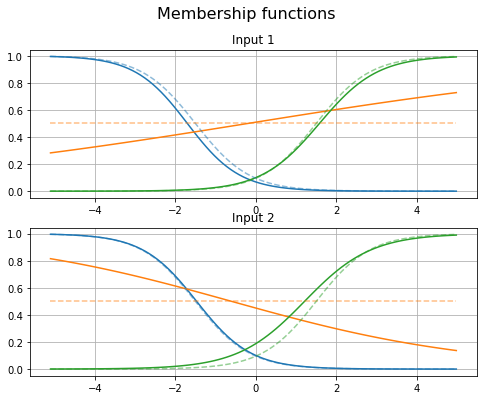

Model: "tfanfis"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputLayer (InputLayer)        [(32, 2)]            0           []                               
                                                                                                  
 fuzzyLayer (FuzzyLayer)        (32, 3, 2)           12          ['inputLayer[0][0]']             
                                                                                                  
 ruleLayer (RuleLayer)          (32, 9)              0           ['fuzzyLayer[0][0]']             
                                                                                                  
 normLayer (NormLayer)          (32, 9)              0           ['ruleLayer[0][0]']              
                                                                                            

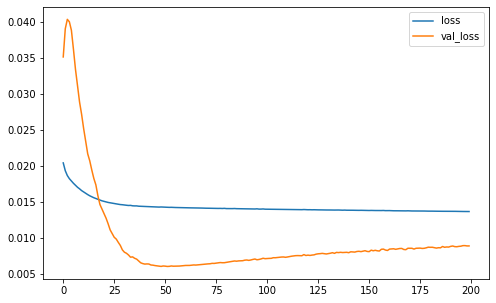

In [40]:
fis = tfanfis.ANFIS(
    n_input = param.n_input,
    n_memb = param.n_memb,
    batch_size = param.batch_size,
    memb_func = param.memb_func,
    name = 'tfanfis'
)

# compile model
fis.model.compile(
    optimizer=param.optimizer,
    loss=param.loss
    #,metrics=['mse']  # ['mae', 'mse']
)

# fit model
history = fis.fit(
    X_train, y_train,
    epochs=param.n_epochs,
    batch_size=param.batch_size,
    validation_data = (X_test, y_test),
    # callbacks = [tensorboard_callback]  # for tensorboard
)

# eval model
fis.plotmfs(show_initial_weights=True)

loss_curves = pd.DataFrame(history.history)
loss_curves.plot(figsize=(8, 5))

fis.model.summary()

# get premise parameters
premise_parameters = fis.model.get_layer('fuzzyLayer').get_weights()       # alternative

# get consequence paramters
bias = fis.bias
weights = fis.weights
# conseq_parameters = fis.model.get_layer('defuzzLayer').get_weights()       # alternative


In [43]:
trainpredict = fis.model.predict(
    X_train
)
testpredict = fis.model.predict(
    X_test
)

# fis(X_test)
def mape(actual, forecast):
    # https://www.forecastpro.com/2020/08/24/how-do-i-measure-forecast-accuracy/
    # MAPE (Mean Absolute Percent Error)
    # 1/n sum((actual-forecast)/actual) * 100
    return (1/len(actual) * sum((actual-forecast)/actual)) * 100

def mapeAccuracy(testy, testpredict):
    err = abs(mape(testy, testpredict))
    return {
        'acc': 100-err,
        'err': err
    }


mapeAccuracy(y_test.flatten(), testpredict.flatten())
# mape(np.array([1,2,3]),np.array([2,2,3]))
# testy, testpredict

{'acc': 81.93845208002298, 'err': 18.061547919977023}

(320, 1)
(128, 1)
(448,)
(448,)


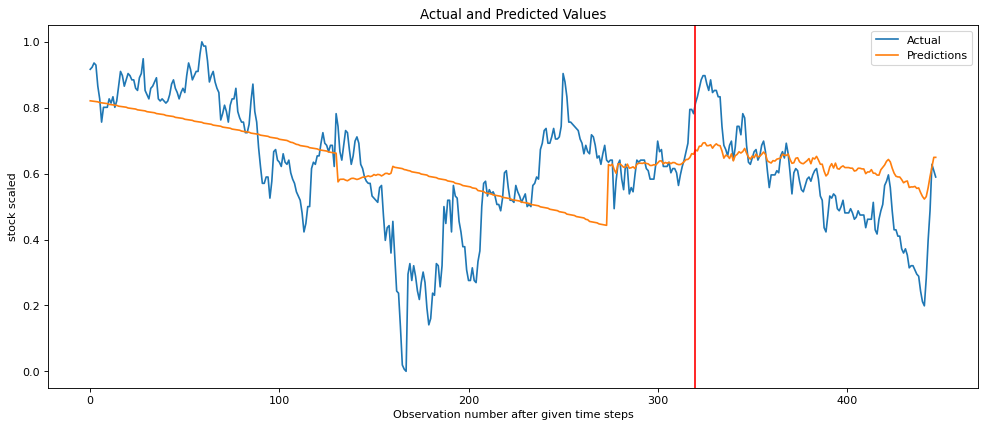

In [42]:
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    print(trainY.shape)
    print(testY.shape)
    print(actual.shape)
    print(predictions.shape)
    
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('stock scaled')
    plt.title('Actual and Predicted Values')

plot_result(y_train, y_test, trainpredict, testpredict)